In [1]:
import pandas as pd
import os
import glob
from datetime import datetime

# 1. LOAD FILE LIST
# If you saved the CSV from the previous step:
# df = pd.read_csv("mea_file_locations.csv")

# OR, if you want to run it fresh right now:
root_search_path = "/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedData/CDKL5_T1"
files = glob.glob(os.path.join(root_search_path, "**", "*network*.json"), recursive=True)
df = pd.DataFrame(files, columns=['full_path'])

def parse_path_metadata(path):
    """
    Extracts metadata from the standard path structure:
    .../AnalyzedData/Genotype/Date/ChipID/Network/RunID/WellID/...
    """
    try:
        parts = path.split(os.sep)
        
        # We anchor everything relative to "AnalyzedData" to be safe
        if "AnalyzedData" in parts:
            idx = parts.index("AnalyzedData")
            
            # Extract based on your specific directory depth
            project = parts[idx + 1]  # e.g., CDKL5_T1
            date_str = parts[idx + 2]  # e.g., 240531
            chip_id  = parts[idx + 3]  # e.g., M07420
            # parts[idx + 4] is usually "Network"
            run_id   = parts[idx + 5]  # e.g., 000052
            well_id  = parts[idx + 6]  # e.g., well005
            
            return pd.Series([project, date_str, chip_id, run_id, well_id])
        else:
            return pd.Series([None, None, None, None, None])
            
    except IndexError:
        return pd.Series([None, None, None, None, None])

# 2. APPLY EXTRACTION
print(" dissecting path names...")
metadata_cols = ["Project", "Date", "Chip_ID", "RunID", "Well"]
df[metadata_cols] = df['full_path'].apply(parse_path_metadata)
#puth full_path to last column
df = df[[col for col in df.columns if col != 'full_path'] + ['full_path']]


# 4. REVIEW
print(f"Successfully dissected {len(df)} paths.")
print("\nSnapshot of extracted metadata:")
print(df.head())

# 5. SAVE
df.to_csv("/pscratch/sd/m/mpatil1/MEA_Analysis/IPNAnalysis/workbooks/mea_metadata_index.csv", index=False)

 dissecting path names...
Successfully dissected 367 paths.

Snapshot of extracted metadata:
    Project    Date Chip_ID   RunID     Well  \
0  CDKL5_T1  240607  M08018  000095  well000   
1  CDKL5_T1  240607  M08018  000095  well003   
2  CDKL5_T1  240607  M08018  000095  well004   
3  CDKL5_T1  240607  M08018  000095  well001   
4  CDKL5_T1  240607  M08018  000095  well002   

                                           full_path  
0  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...  
1  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...  
2  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...  
3  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...  
4  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...  


In [2]:
import json
import pandas as pd

# 1. Select the first file from our dissected dataframe
# We use .iloc[0] to grab the first row
sample_path = df.iloc[0]['full_path']
#print(f"Inspecting file: {sample_path}\n")
#sample_path = '/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedData/CDKL5_T1/240531/M07420/Network/000052/well004/network_results.json'
# 2. Load the JSON data
with open(sample_path, 'r') as f:
    data = json.load(f)

# 3. Helper function to print the structure without flooding the screen
# This will show you the Keys and the Type of data inside (e.g., float, list of 6000 items)
def print_structure(d, indent=0):
    spacing = "  " * indent
    if isinstance(d, dict):
        for key, value in d.items():
            if isinstance(value, dict):
                print(f"{spacing}- {key}: (Nested Dictionary)")
                print_structure(value, indent + 1)
            elif isinstance(value, list):
                print(f"{spacing}- {key}: List [{len(value)} items]")
            else:
                print(f"{spacing}- {key}: {type(value).__name__} (e.g., {value})")
    else:
        print(f"{spacing} (Not a dictionary)")

# 4. Print the "Map" of your JSON
print("--- JSON FILE STRUCTURE ---")
print_structure(data)

# 5. Check for specific "Gold Mine" keys
# These are the standard keys usually found in MaxWell/MACS outputs.
# We try to print them specifically to see if they exist.
print("\n--- CHECKING FOR COMMON METRICS ---")
possible_keys = ['mean_firing_rate', 'mean_burst_rate', 'network_burst_frequency', 'burst_duration_mean']

found_metrics = {}
for key in possible_keys:
    # Check top level
    if key in data:
        found_metrics[key] = data[key]
    # Sometimes metrics are hidden inside a 'summary' or 'network' sub-dictionary
    elif 'summary' in data and key in data['summary']:
        found_metrics[key] = data['summary'][key]

print(f"Found specific metrics: {json.dumps(found_metrics, indent=2)}")

--- JSON FILE STRUCTURE ---
- burstlets: (Nested Dictionary)
  - events: List [188 items]
  - metrics: (Nested Dictionary)
    - count: int (e.g., 188)
    - rate_bpm: float (e.g., 37.59035180970217)
    - duration: (Nested Dictionary)
      - mean: float (e.g., 0.46510638297872536)
      - std: float (e.g., 0.40976964125643556)
      - cv: float (e.g., 0.881023473881628)
    - inter_event_interval: (Nested Dictionary)
      - mean: float (e.g., 1.5843850267379678)
      - std: float (e.g., 2.0463853671793473)
      - cv: float (e.g., 1.291596002641211)
    - intensity: (Nested Dictionary)
      - mean: float (e.g., 81.43521736620606)
      - std: float (e.g., 89.14963603406281)
      - cv: float (e.g., 1.0947307432503774)
    - participation: (Nested Dictionary)
      - mean: float (e.g., 0.5228601591684263)
      - std: float (e.g., 0.17054460355927134)
      - cv: float (e.g., 0.32617632184963374)
- network_bursts: (Nested Dictionary)
  - events: List [84 items]
  - metrics: (Nested

In [3]:
import json
import pandas as pd
import numpy as np
import os

# --- 1. SETUP & PROGRESS BAR ---
try:
    from tqdm import tqdm
    tqdm.pandas()
    # Assuming 'df' is your existing dataframe with file paths
    print("Progress bar enabled.")
except ImportError:
    def tqdm(x, **kwargs): return x
    print("Install 'tqdm' for a progress bar. Running standard loop...")
def extract_metrics(row):
    path = row['full_path']

    metrics = {
        # -------- Network Bursts (NB) --------
        "nb_count": np.nan,
        "nb_rate_hz": np.nan,
        "nb_duration_mean_s": np.nan,
        "nb_ibi_mean_s": np.nan,
        "nb_intensity_mean": np.nan,
        "nb_participation_mean": np.nan,

        "nb_durations_list": [],
        "nb_peak_list": [],
        "nb_intensity_list": [],
        "nb_synchrony_energy_list": [],

        # -------- Superbursts (SB) --------
        "sb_count": np.nan,
        "sb_rate_hz": np.nan,
        "sb_duration_mean_s": np.nan,
        "sb_ibi_mean_s": np.nan,
        "sb_intensity_mean": np.nan,
        "sb_participation_mean": np.nan,

        "sb_durations_list": [],
        "sb_peak_list": [],
        "sb_intensity_list": [],
        "sb_synchrony_energy_list": [],

        # -------- Burstlets (BL) --------
        "bl_count": np.nan,
        "bl_rate_hz": np.nan,
        "bl_duration_mean_s": np.nan,
        "bl_ibi_mean_s": np.nan,
        "bl_intensity_mean": np.nan,
        "bl_participation_mean": np.nan,


        "bl_durations_list": [],
        "bl_peak_list": [],
        "bl_intensity_list": [],   
        "bl_synchrony_energy_list": [],
    }

    try:
        with open(path, "r") as f:
            data = json.load(f)

        # ---------- Helper ----------
        def extract_block(block, prefix):
            if block is None:
                return

            m = block.get("metrics", {})
            events = block.get("events", [])

            metrics[f"{prefix}_count"] = m.get("count", np.nan)

            if "rate_bpm" in m:
                metrics[f"{prefix}_rate_hz"] = m["rate_bpm"] / 60.0

            metrics[f"{prefix}_duration_mean_s"] = m.get("duration", {}).get("mean")
            metrics[f"{prefix}_ibi_mean_s"] = m.get("inter_event_interval", {}).get("mean")
            metrics[f"{prefix}_intensity_mean"] = m.get("intensity", {}).get("mean")
            metrics[f"{prefix}_participation_mean"] = m.get("participation", {}).get("mean")

            # --- Raw Distributions ---
            for ev in events:
                if "duration_s" in ev:
                    metrics[f"{prefix}_durations_list"].append(ev["duration_s"])
                if "peak_synchrony" in ev:
                    metrics[f"{prefix}_peak_list"].append(ev["peak_synchrony"])
                if "synchrony_energy" in ev:
                    metrics[f"{prefix}_synchrony_energy_list"].append(ev["synchrony_energy"])
                if "total_spikes" in ev:
                    metrics[f"{prefix}_intensity_list"].append(ev["total_spikes"])
                
                
                

        # ---------- Apply ----------
        extract_block(data.get("network_bursts"), "nb")
        extract_block(data.get("superbursts"), "sb")
        extract_block(data.get("burstlets"), "bl")

    except Exception as e:
        print(f"[ERROR] {path}: {e}")

    return pd.Series(metrics)

# --- 3. RUN EXTRACTION ---
print("Starting unified extraction (Scalars + Lists)...")

# If you have tqdm installed, use progress_apply, otherwise use apply
if hasattr(tqdm, 'pandas'):
    df_metrics = df.progress_apply(extract_metrics, axis=1)
else:
    df_metrics = df.apply(extract_metrics, axis=1)

# Concatenate metadata with results
result_df = pd.concat([df, df_metrics], axis=1)



Progress bar enabled.
Starting unified extraction (Scalars + Lists)...


  0%|                                                                                                                                                                                   | 0/367 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 367/367 [00:00<00:00, 407.72it/s]


In [4]:
print(result_df.columns)

Index(['Project', 'Date', 'Chip_ID', 'RunID', 'Well', 'full_path', 'nb_count',
       'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
       'nb_intensity_mean', 'nb_participation_mean', 'nb_durations_list',
       'nb_peak_list', 'nb_intensity_list', 'nb_synchrony_energy_list',
       'sb_count', 'sb_rate_hz', 'sb_duration_mean_s', 'sb_ibi_mean_s',
       'sb_intensity_mean', 'sb_participation_mean', 'sb_durations_list',
       'sb_peak_list', 'sb_intensity_list', 'sb_synchrony_energy_list',
       'bl_count', 'bl_rate_hz', 'bl_duration_mean_s', 'bl_ibi_mean_s',
       'bl_intensity_mean', 'bl_participation_mean', 'bl_durations_list',
       'bl_peak_list', 'bl_intensity_list', 'bl_synchrony_energy_list'],
      dtype='object')


In [4]:
ref_df = pd.read_excel("/pscratch/sd/m/mpatil1/Data/CDKL5_T1/CDKL5_T1_C1_reff.xlsx")
print(ref_df.columns)




# --- 2. TRANSFORMATION LOGIC ---

# Step A: Split the strings into actual Python lists
# We split by comma and implicitly handle the 1:1 mapping
ref_df['Wells_List'] = ref_df['Wells_Recorded'].astype(str).str.split(',')
ref_df['Source_List'] = ref_df['Neuron Source'].astype(str).str.split(',')

# Step B: Explode the lists into rows
# Pandas >= 1.3.0 allows exploding multiple columns simultaneously to keep them aligned
# This is crucial so Index 0 of Wells stays with Index 0 of Source
exploded_df = ref_df.explode(['Wells_List', 'Source_List'])

# Step C: Cleanup
# Remove whitespace that might exist in the strings (e.g., " MxWT" -> "MxWT")
exploded_df['Well'] = exploded_df['Wells_List'].str.strip()
exploded_df['NeuronType'] = exploded_df['Source_List'].str.strip()

# Step D: Create a "Match Key" for merging with your JSON results
# Your files are named like 'well005', so we format the number '5' -> 'well005'
exploded_df['Well'] = 'well' + exploded_df['Well'].str.zfill(3)

# Filter to keep only the clean columns
clean_ref_df = exploded_df[['Date', 'ID', 'Run #','Well', 'NeuronType', 'Assay', 'DIV']]

# --- 3. VIEW RESULTS ---
print(f"Transformation complete.")
print(f"Original rows: {len(ref_df)}")
print(f"Exploded rows: {len(clean_ref_df)}")
print("\nFirst 10 rows of clean metadata:")
print(clean_ref_df.head(10))

# Save this for the next step
#clean_ref_df.to_csv("clean_metadata_map.csv", index=False)

Index(['Date', 'DIV', 'Assay', 'Run #', 'ID', 'Wells_Recorded',
       'Neuron Source'],
      dtype='object')
Transformation complete.
Original rows: 109
Exploded rows: 654

First 10 rows of clean metadata:
        Date      ID  Run #     Well NeuronType          Assay  DIV
0 2024-05-20  M07420      1  well001       MxWT       Sparse7x    5
0 2024-05-20  M07420      1  well002       MxWT       Sparse7x    5
0 2024-05-20  M07420      1  well003       MxWT       Sparse7x    5
0 2024-05-20  M07420      1  well004      FxHET       Sparse7x    5
0 2024-05-20  M07420      1  well005      FxHET       Sparse7x    5
0 2024-05-20  M07420      1  well006      FxHET       Sparse7x    5
1 2024-05-20  M07420      2  well001       MxWT  Network Today    5
1 2024-05-20  M07420      2  well002       MxWT  Network Today    5
1 2024-05-20  M07420      2  well003       MxWT  Network Today    5
1 2024-05-20  M07420      2  well004      FxHET  Network Today    5


In [5]:
clean_ref_df.columns

Index(['Date', 'ID', 'Run #', 'Well', 'NeuronType', 'Assay', 'DIV'], dtype='object')

In [6]:
result_df.columns

Index(['Project', 'Date', 'Chip_ID', 'RunID', 'Well', 'full_path', 'nb_count',
       'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
       'nb_intensity_mean', 'nb_participation_mean', 'nb_durations_list',
       'nb_peak_list', 'nb_intensity_list', 'nb_synchrony_energy_list',
       'sb_count', 'sb_rate_hz', 'sb_duration_mean_s', 'sb_ibi_mean_s',
       'sb_intensity_mean', 'sb_participation_mean', 'sb_durations_list',
       'sb_peak_list', 'sb_intensity_list', 'sb_synchrony_energy_list',
       'bl_count', 'bl_rate_hz', 'bl_duration_mean_s', 'bl_ibi_mean_s',
       'bl_intensity_mean', 'bl_participation_mean', 'bl_durations_list',
       'bl_peak_list', 'bl_intensity_list', 'bl_synchrony_energy_list'],
      dtype='object')

In [7]:
result_df.rename(columns={"RunID": "Run #","Chip_ID": "ID"}, inplace=True)

In [8]:
#make Run # elements to int
result_df['Run #'] = result_df['Run #'].astype(int)

In [9]:
print(result_df['Well'].unique()[:10])
print(clean_ref_df['Well'].unique()[:10])

['well000' 'well003' 'well004' 'well001' 'well002' 'well005']
['well001' 'well002' 'well003' 'well004' 'well005' 'well006']


In [10]:
# --- Harmonize Date dtype BEFORE merge ---


# --- Merge ---
merged_df = pd.merge(
    result_df,
    clean_ref_df,
    how='left',
    left_on=['ID', 'Well', 'Run #'],
    right_on=['ID', 'Well', 'Run #'],
    validate='many_to_one'  # or 'one_to_one' if applicable
)

In [11]:
merged_df.head()

,Project,Date_x,ID,Run #,Well,full_path,nb_count,nb_rate_hz,nb_duration_mean_s,nb_ibi_mean_s,...,bl_intensity_mean,bl_participation_mean,bl_durations_list,bl_peak_list,bl_intensity_list,bl_synchrony_energy_list,Date_y,NeuronType,Assay,DIV
0,CDKL5_T1,240607,M08018,95,well000,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,84,0.279928,0.861310,3.566024,...,81.435217,0.522860,"[0.3799999999999999, 1.4099999999999993, 0.109...","[188.79328212210604, 228.79304361892662, 197.4...","[444, 1548, 159, 203, 106, 1001, 1591, 173, 84...","[50.22343210385691, 178.58635835522588, 16.318...",NaT,NaN,NaN,NaN
1,CDKL5_T1,240607,M08018,95,well003,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,83,0.276596,0.659880,3.585366,...,60.515440,0.583186,"[0.22999999999999998, 0.7400000000000002, 0.10...","[351.99055926633605, 162.33593146687852, 167.5...","[327, 650, 133, 107, 640, 219, 148, 255, 52, 2...","[22.537675867990767, 57.82683677530648, 11.280...",2024-06-07,FxHET,Neuronal Units 9,23.0
2,CDKL5_T1,240607,M08018,95,well004,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,106,0.353247,0.224717,2.829429,...,7.454045,0.531157,"[0.1900000000000004, 0.2799999999999998, 0.260...","[56.246051819519664, 118.15405852797586, 129.0...","[89, 213, 195, 102, 180, 249, 98, 200, 200, 22...","[2.8272946186496206, 10.50367890411455, 12.202...",2024-06-07,MxHEMI,Neuronal Units 9,23.0
3,CDKL5_T1,240607,M08018,95,well001,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,379,1.263185,0.587652,0.791481,...,12.366148,0.368695,"[0.09, 0.25, 0.41999999999999993, 0.3300000000...","[47.01906247843521, 51.66182206803928, 61.7899...","[60, 167, 274, 201, 112, 126, 65, 585, 144, 21...","[3.814259226923133, 9.988793715534353, 17.6023...",2024-06-07,MxHEMI,Neuronal Units 9,23.0
4,CDKL5_T1,240607,M08018,95,well002,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,54,0.179956,0.405185,5.448679,...,52.772499,0.622665,"[0.33000000000000007, 0.1999999999999993, 0.42...","[529.5810482831753, 266.2000160279836, 736.041...","[531, 231, 928, 522, 131, 717, 449, 117, 819, ...","[52.241679109270706, 12.513551837632054, 124.9...",2024-06-07,MxWT,Neuronal Units 9,23.0


In [12]:
#keep only DateX and delete Date_y
merged_df.drop(columns=['Date_y'], inplace=True)
merged_df.rename(columns={"Date_x": "Date"}, inplace=True)

In [13]:
#order by run #
merged_df.sort_values(by=['ID', 'Run #', 'Well'], inplace=True)

In [14]:
merged_df.head()

,Project,Date,ID,Run #,Well,full_path,nb_count,nb_rate_hz,nb_duration_mean_s,nb_ibi_mean_s,...,bl_ibi_mean_s,bl_intensity_mean,bl_participation_mean,bl_durations_list,bl_peak_list,bl_intensity_list,bl_synchrony_energy_list,NeuronType,Assay,DIV
233,CDKL5_T1,240520,M07039,6,well000,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,7,0.023332,0.625714,47.165000,...,25.726364,57.488993,0.609214,"[0.8499999999999999, 0.06999999999999984, 0.16...","[1441.917232212386, 636.528104651716, 863.2603...","[2398, 206, 486, 770, 986, 864, 420, 287, 1897...","[215.84761798622966, 17.441206163998523, 40.72...",NaN,NaN,NaN
236,CDKL5_T1,240520,M07039,6,well001,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,2,0.006666,149.620000,158.930000,...,0.370965,38.763820,0.439185,"[0.24000000000000002, 0.58, 0.1800000000000000...","[36.12322248003121, 48.62764606261954, 45.3030...","[129, 359, 112, 973, 303, 145, 148, 411, 261, ...","[9.866532933884075, 23.903467048631825, 7.4294...",MxHEMI,Network Today,5.0
237,CDKL5_T1,240520,M07039,6,well002,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,3,0.010000,0.586667,84.100000,...,33.616000,31.348503,0.563934,"[0.04999999999998295, 0.5099999999999909, 0.06...","[729.3134876664037, 1340.3341417055074, 706.14...","[147, 1388, 191, 1262, 262, 1388]","[6.007156413508685, 61.054240632788634, 5.9342...",MxWT,Network Today,5.0
234,CDKL5_T1,240520,M07039,6,well003,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,15,0.050002,1.040667,18.882143,...,12.015909,31.317639,0.615307,"[0.79, 0.15999999999999998, 1.1899999999999977...","[1186.5349332280425, 849.0157007527298, 145.14...","[1970, 457, 769, 116, 1511, 1032, 442, 663, 45...","[157.90645881520487, 31.96242798413465, 19.460...",FxHET,Network Today,5.0
235,CDKL5_T1,240520,M07039,6,well004,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,1,0.003333,0.640000,0.000000,...,-0.130000,97.867300,0.674807,"[0.22000000000002728, 0.6400000000000148]","[1561.2016704219582, 1563.9134126568122]","[896, 2177]","[50.28750018995671, 145.44710047874145]",MxHEMI,Network Today,5.0


In [15]:
#Calcuate DIV based on Date and Date of plating
plating_date = '240515'
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%y%m%d')
plating_date_dt = pd.to_datetime(plating_date, format='%y%m%d')
merged_df['DIV'] = (merged_df['Date'] - plating_date_dt).dt.days
merged_df.head()

,Project,Date,ID,Run #,Well,full_path,nb_count,nb_rate_hz,nb_duration_mean_s,nb_ibi_mean_s,...,bl_ibi_mean_s,bl_intensity_mean,bl_participation_mean,bl_durations_list,bl_peak_list,bl_intensity_list,bl_synchrony_energy_list,NeuronType,Assay,DIV
233,CDKL5_T1,2024-05-20,M07039,6,well000,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,7,0.023332,0.625714,47.165000,...,25.726364,57.488993,0.609214,"[0.8499999999999999, 0.06999999999999984, 0.16...","[1441.917232212386, 636.528104651716, 863.2603...","[2398, 206, 486, 770, 986, 864, 420, 287, 1897...","[215.84761798622966, 17.441206163998523, 40.72...",NaN,NaN,5
236,CDKL5_T1,2024-05-20,M07039,6,well001,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,2,0.006666,149.620000,158.930000,...,0.370965,38.763820,0.439185,"[0.24000000000000002, 0.58, 0.1800000000000000...","[36.12322248003121, 48.62764606261954, 45.3030...","[129, 359, 112, 973, 303, 145, 148, 411, 261, ...","[9.866532933884075, 23.903467048631825, 7.4294...",MxHEMI,Network Today,5
237,CDKL5_T1,2024-05-20,M07039,6,well002,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,3,0.010000,0.586667,84.100000,...,33.616000,31.348503,0.563934,"[0.04999999999998295, 0.5099999999999909, 0.06...","[729.3134876664037, 1340.3341417055074, 706.14...","[147, 1388, 191, 1262, 262, 1388]","[6.007156413508685, 61.054240632788634, 5.9342...",MxWT,Network Today,5
234,CDKL5_T1,2024-05-20,M07039,6,well003,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,15,0.050002,1.040667,18.882143,...,12.015909,31.317639,0.615307,"[0.79, 0.15999999999999998, 1.1899999999999977...","[1186.5349332280425, 849.0157007527298, 145.14...","[1970, 457, 769, 116, 1511, 1032, 442, 663, 45...","[157.90645881520487, 31.96242798413465, 19.460...",FxHET,Network Today,5
235,CDKL5_T1,2024-05-20,M07039,6,well004,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,1,0.003333,0.640000,0.000000,...,-0.130000,97.867300,0.674807,"[0.22000000000002728, 0.6400000000000148]","[1561.2016704219582, 1563.9134126568122]","[896, 2177]","[50.28750018995671, 145.44710047874145]",MxHEMI,Network Today,5


In [16]:
merged_df.columns

Index(['Project', 'Date', 'ID', 'Run #', 'Well', 'full_path', 'nb_count',
       'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
       'nb_intensity_mean', 'nb_participation_mean', 'nb_durations_list',
       'nb_peak_list', 'nb_intensity_list', 'nb_synchrony_energy_list',
       'sb_count', 'sb_rate_hz', 'sb_duration_mean_s', 'sb_ibi_mean_s',
       'sb_intensity_mean', 'sb_participation_mean', 'sb_durations_list',
       'sb_peak_list', 'sb_intensity_list', 'sb_synchrony_energy_list',
       'bl_count', 'bl_rate_hz', 'bl_duration_mean_s', 'bl_ibi_mean_s',
       'bl_intensity_mean', 'bl_participation_mean', 'bl_durations_list',
       'bl_peak_list', 'bl_intensity_list', 'bl_synchrony_energy_list',
       'NeuronType', 'Assay', 'DIV'],
      dtype='object')

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem, ttest_ind

plt.rcParams.update({
    "font.family": "Arial",
    "axes.edgecolor": "black",
    "axes.linewidth": 1.0,
    "axes.labelsize": 14,
    "axes.labelweight": "bold",
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "legend.title_fontsize": 13
})

def plot_scalar_line_ttest_vs_control(
    df,
    value_col,
    control_group='MxWT',   # <--- DEFINE YOUR CONTROL HERE
    feature_label=None,
    order=('MxWT', 'FxHET', 'MxHEMI'),
    palette={'MxWT': '#1f77b4', 'FxHET': '#c77b1b', 'MxHEMI': '#d62728'},
    save_path=None
):
    """
    Lineplot comparing specific groups against a Control (WT) using T-tests.
    Skips comparisons between mutants (e.g., HET vs HEMI).
    """

    # 1. Prepare Data
    sub = df[['DIV', 'NeuronType', 'ID', 'Well', value_col]].copy()
    sub['ChipID_Well'] = sub['ID'].astype(str) + '_W' + sub['Well'].astype(str)
    sub = sub.dropna(subset=[value_col])
    
    # 2. Aggregation (Mean per Well)
    agg_df = sub.groupby(['DIV', 'ChipID_Well', 'NeuronType'])[value_col].mean().reset_index()

    # 3. Summary stats for plotting
    summary = (
        agg_df.groupby(['DIV', 'NeuronType'])
        .agg(mean_value=(value_col, 'mean'), sem_value=(value_col, sem))
        .reset_index()
    )

    divs = sorted(agg_df['DIV'].unique())
    group_offsets = {g: (i - len(order)/2 + 0.5) * 0.3 for i, g in enumerate(order)} # Dynamic offsets

    # 4. PLOTTING
    fig, ax = plt.subplots(figsize=(8, 4.8))

    # Background Scatter
    for nt in order:
        if nt not in palette: continue
        sub_nt = agg_df[agg_df['NeuronType'] == nt]
        jitter = (np.random.rand(len(sub_nt)) - 0.5) * 0.15
        ax.scatter(sub_nt['DIV'] + jitter + group_offsets[nt],
                   sub_nt[value_col], color=palette[nt], alpha=0.4,
                   s=20, edgecolor='none', zorder=1)

    # Foreground Lines
    for nt in order:
        if nt not in palette: continue
        sub_nt = summary[summary['NeuronType'] == nt]
        offset = group_offsets[nt]
        ax.plot(sub_nt['DIV'] + offset, sub_nt['mean_value'], '-o',
                color=palette[nt], lw=2.5, zorder=3, label=nt)
        ax.fill_between(sub_nt['DIV'] + offset,
                        sub_nt['mean_value'] - sub_nt['sem_value'],
                        sub_nt['mean_value'] + sub_nt['sem_value'],
                        color=palette[nt], alpha=0.2, zorder=2)

    # 5. STATISTICS (Targeted T-Tests)
    # We only loop through the NON-CONTROL groups and compare them to CONTROL
    sig_results = []
    
    for div in divs:
        day_data = agg_df[agg_df['DIV'] == div]
        
        # Get Control Data for this day
        ctrl_vals = day_data[day_data['NeuronType'] == control_group][value_col]
        if len(ctrl_vals) < 2: continue # Need at least 2 points for stats
        
        # Compare every other group to Control
        for group in order:
            if group == control_group: continue
            
            exp_vals = day_data[day_data['NeuronType'] == group][value_col]
            if len(exp_vals) < 2: continue
            
            # RUN INDEPENDENT T-TEST (Welch's t-test recommended: equal_var=False)
            t_stat, p_val = ttest_ind(ctrl_vals, exp_vals, equal_var=False, nan_policy='omit')
            
            if p_val < 0.05:
                sig_results.append({
                    'div': div, 
                    'g1': control_group, 
                    'g2': group, 
                    'p': p_val
                })

    # 6. ANNOTATE SIGNIFICANCE
    ymin, ymax = ax.get_ylim()
    yrange = ymax - ymin
    ax.set_ylim(ymin, ymax + yrange * 0.25) # Add headroom for brackets

    # Sort by p-value to stack brackets nicely
    sig_results.sort(key=lambda x: x['p'])
    
    # Track existing brackets per DIV to avoid overlap
    active_brackets = {d: 0 for d in divs}

    for res in sig_results:
        div = res['div']
        p = res['p']
        g1, g2 = res['g1'], res['g2']
        
        # Determine stars
        if p < 0.001: sig = '***'
        elif p < 0.01: sig = '**'
        else: sig = '*'
        
        # Calculate coordinates
        x1 = div + group_offsets[g1]
        x2 = div + group_offsets[g2]
        
        # Stack brackets higher if multiple exist on same day
        level = active_brackets[div]
        base_h = ymax + (yrange * 0.08 * level)
        bracket_h = yrange * 0.02
        
        # Draw bracket
        ax.plot([x1, x1, x2, x2], 
                [base_h, base_h + bracket_h, base_h + bracket_h, base_h],
                lw=1, c='k', clip_on=False)
        
        # Add text
        ax.text((x1 + x2)/2, base_h + bracket_h, sig, 
                ha='center', va='bottom', color='k', fontsize=12, fontweight='bold')
        
        active_brackets[div] += 1

    # Final Polish
    ax.legend(title='Genotype', frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_xlabel('Days In Vitro (DIV)', weight='bold')
    ax.set_ylabel(feature_label or value_col, weight='bold')
    ax.set_xticks(divs)
    
    # Remove top/right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

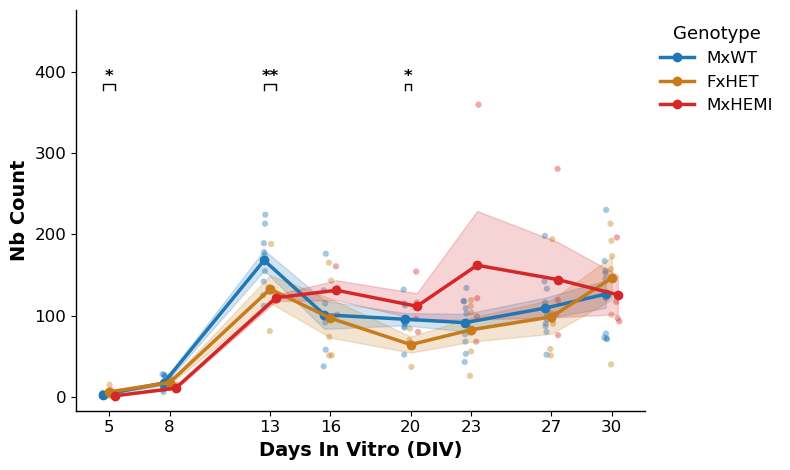

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

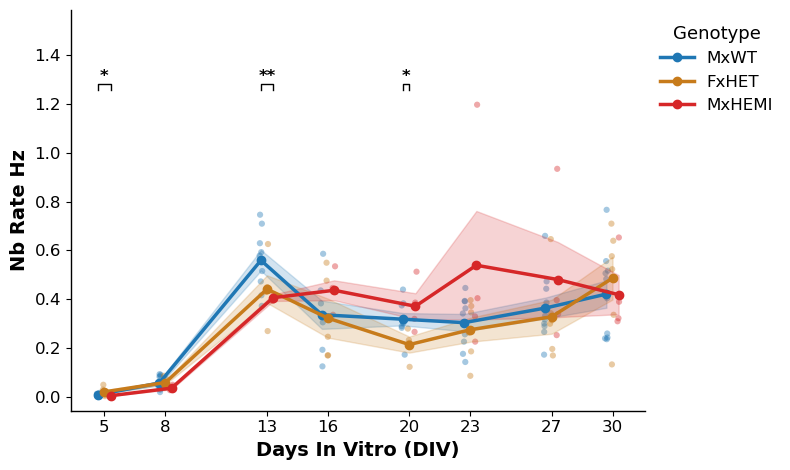

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

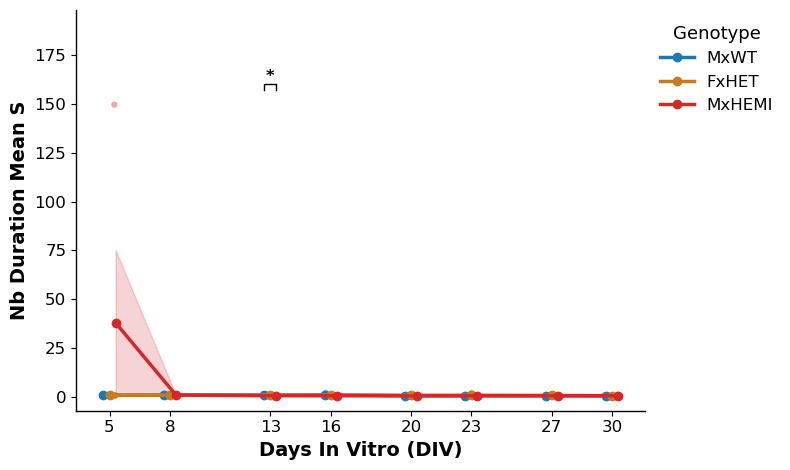

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

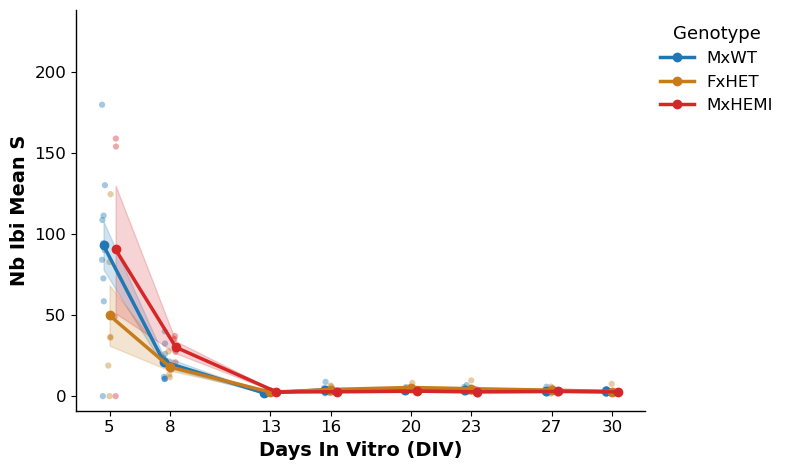

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

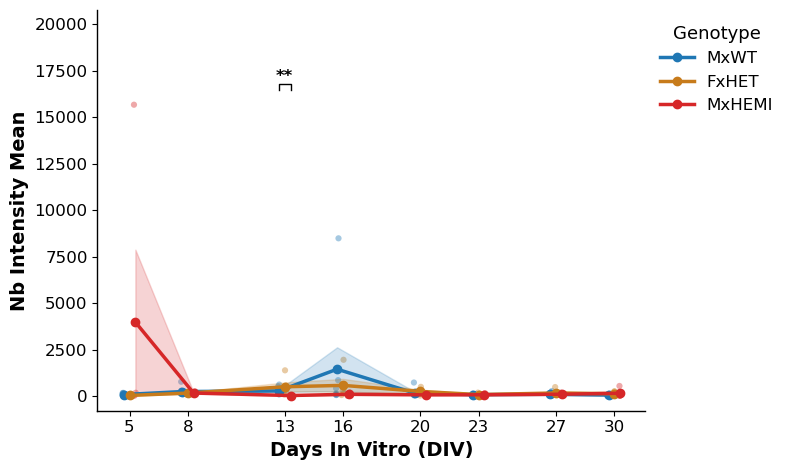

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

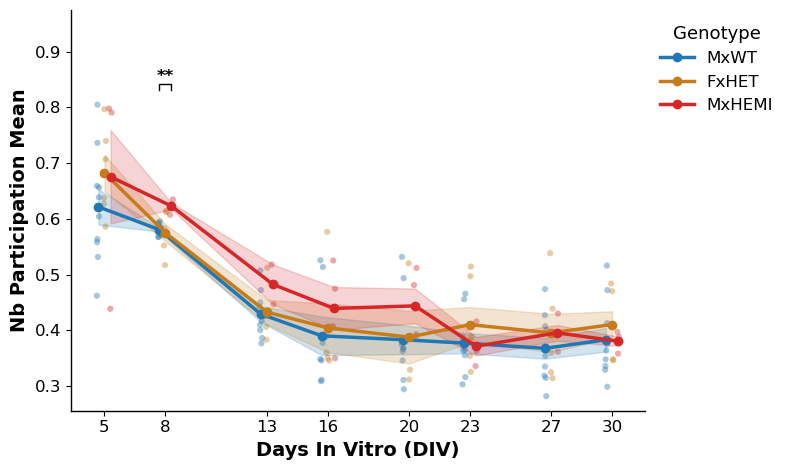

/global/homes/m/mpatil1/.conda/envs/spikeinterface/lib/python3.13/site-packages/pandas/core/groupby/generic.py:324: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f = lambda x: func(x, *args, **kwargs)
/global/homes/m/mpatil1/.conda/envs/spikeinterface/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.

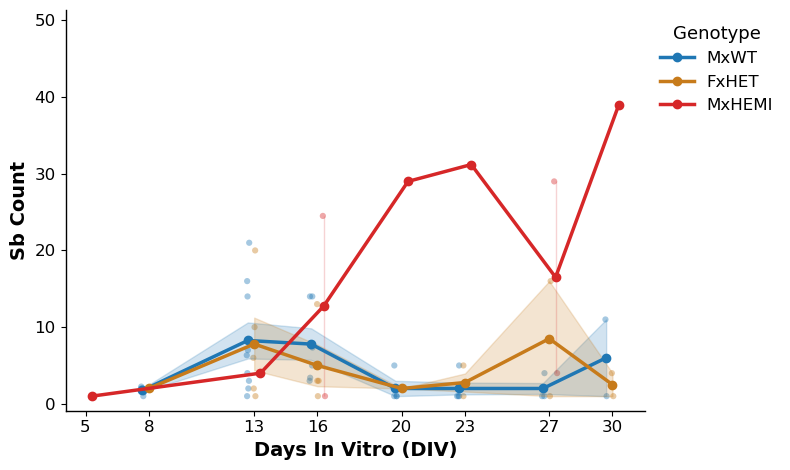

/global/homes/m/mpatil1/.conda/envs/spikeinterface/lib/python3.13/site-packages/pandas/core/groupby/generic.py:324: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f = lambda x: func(x, *args, **kwargs)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
fi

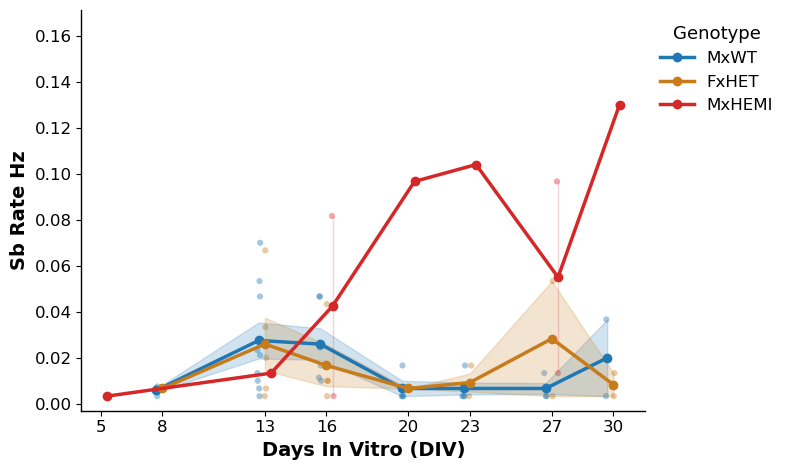

/global/homes/m/mpatil1/.conda/envs/spikeinterface/lib/python3.13/site-packages/pandas/core/groupby/generic.py:324: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f = lambda x: func(x, *args, **kwargs)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
fi

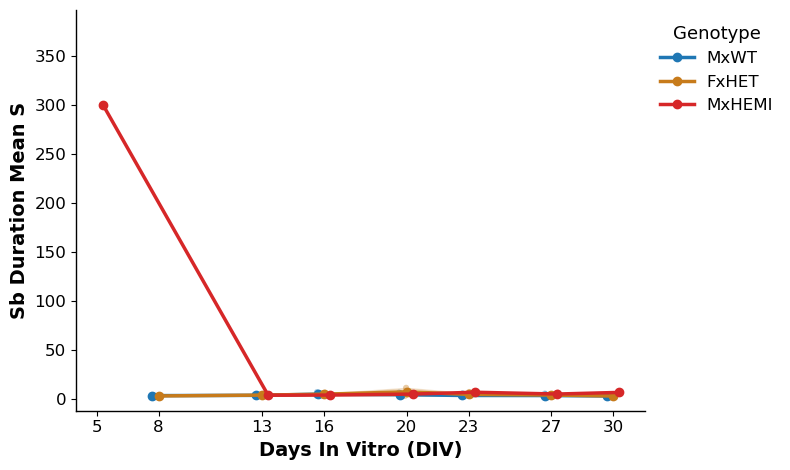

/global/homes/m/mpatil1/.conda/envs/spikeinterface/lib/python3.13/site-packages/pandas/core/groupby/generic.py:324: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f = lambda x: func(x, *args, **kwargs)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
fi

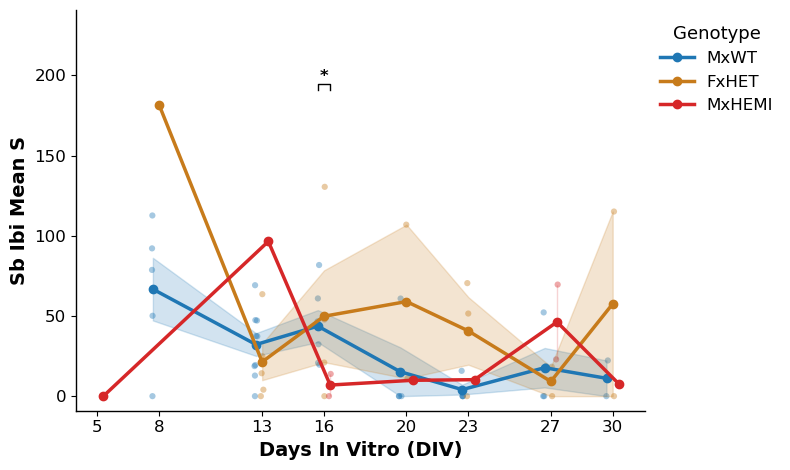

/global/homes/m/mpatil1/.conda/envs/spikeinterface/lib/python3.13/site-packages/pandas/core/groupby/generic.py:324: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f = lambda x: func(x, *args, **kwargs)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
fi

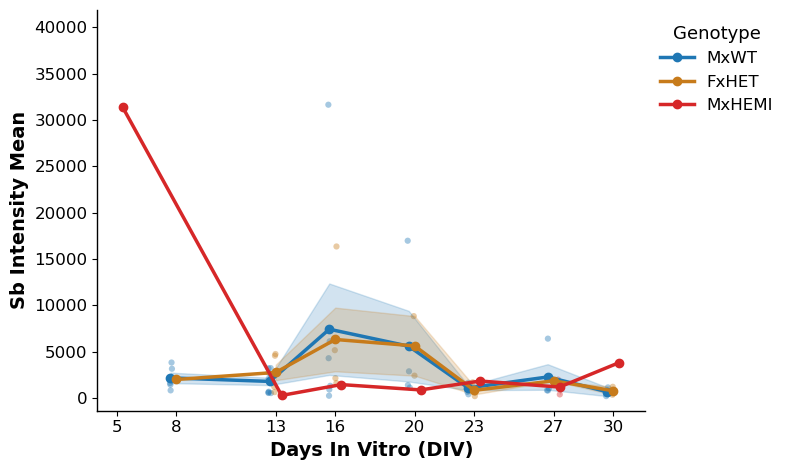

/global/homes/m/mpatil1/.conda/envs/spikeinterface/lib/python3.13/site-packages/pandas/core/groupby/generic.py:324: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f = lambda x: func(x, *args, **kwargs)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
fi

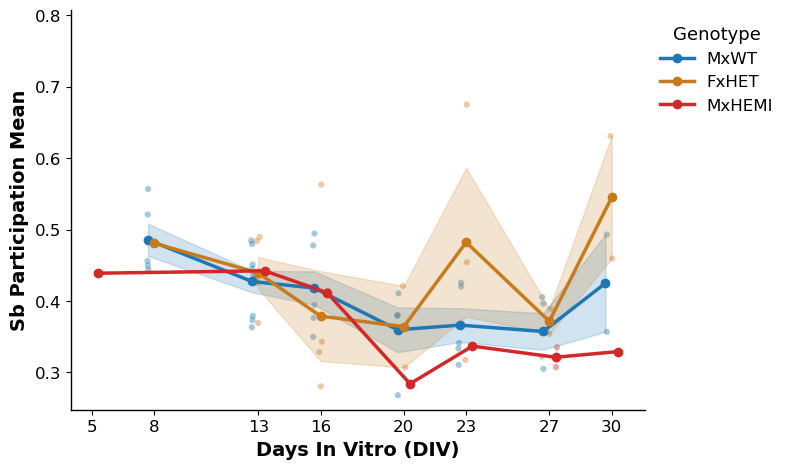

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

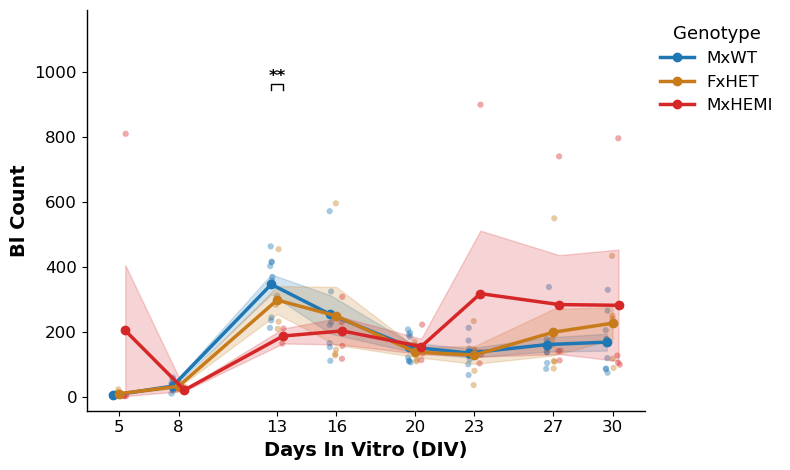

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

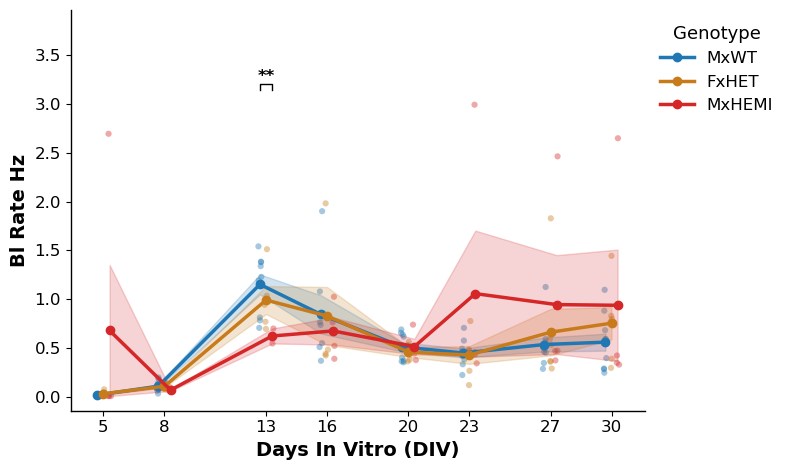

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

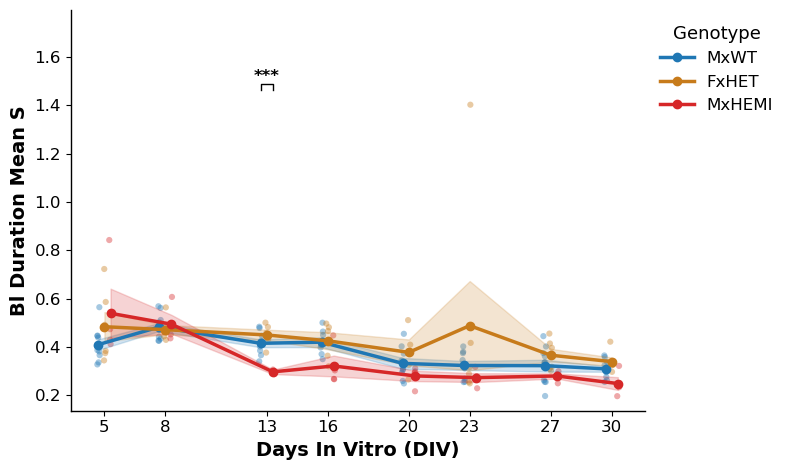

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

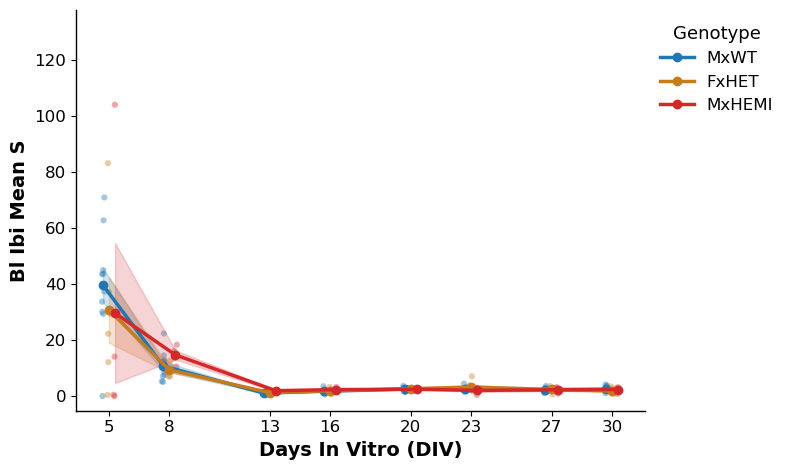

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

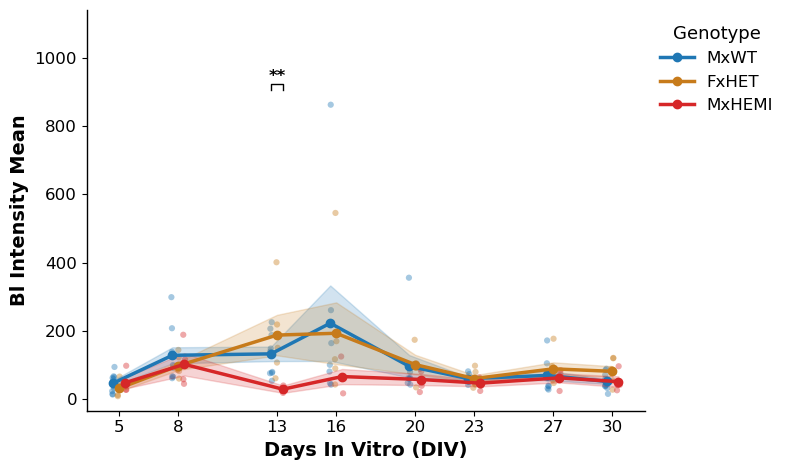

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

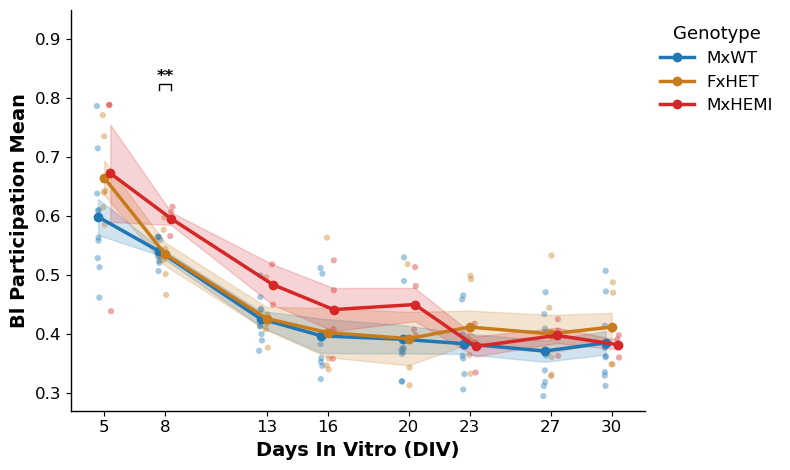

In [18]:
cols_to_plot = [ 'nb_count', 'nb_rate_hz', 'nb_duration_mean_s',
                'nb_ibi_mean_s', 'nb_intensity_mean', 'nb_participation_mean',
                'sb_count', 'sb_rate_hz', 'sb_duration_mean_s', 'sb_ibi_mean_s',
       'sb_intensity_mean', 'sb_participation_mean',
       'bl_count', 'bl_rate_hz', 'bl_duration_mean_s', 'bl_ibi_mean_s',
       'bl_intensity_mean', 'bl_participation_mean'
       ]
for col in cols_to_plot:
    plot_scalar_line_ttest_vs_control(
        merged_df,
        value_col=col,
        feature_label=col.replace('_', ' ').title(),
    )


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem, ttest_ind


def plot_scalar_line_ttest_vs_control(
    df,
    value_col,
    control_group='MxWT',
    feature_label=None,
    order=('MxWT', 'FxHET', 'MxHEMI'),
    palette={'MxWT': '#1f77b4', 'FxHET': '#c77b1b', 'MxHEMI': '#d62728'},
    save_path=None
):
    """
    Lineplot comparing groups vs Control using:
    - Robust y-axis scaling (percentile clip)
    - Lollipop outliers
    - Inline black significance stars with leader ticks
    """

    # ------------------------------------------------------------
    # 1. PREP DATA
    # ------------------------------------------------------------
    sub = df[['DIV', 'NeuronType', 'ID', 'Well', value_col]].copy()
    sub['ChipID_Well'] = sub['ID'].astype(str) + '_W' + sub['Well'].astype(str)
    sub = sub.dropna(subset=[value_col])

    agg_df = (
        sub.groupby(['DIV', 'ChipID_Well', 'NeuronType'])[value_col]
        .mean()
        .reset_index()
    )

    summary = (
        agg_df.groupby(['DIV', 'NeuronType'])
        .agg(mean_value=(value_col, 'mean'),
             sem_value=(value_col, sem))
        .reset_index()
    )

    divs = sorted(agg_df['DIV'].unique())

    group_offsets = {
        g: (i - len(order)/2 + 0.5) * 0.3
        for i, g in enumerate(order)
    }

    # ------------------------------------------------------------
    # 2. ROBUST Y LIMITS (VISUALIZATION ONLY)
    # ------------------------------------------------------------
    yvals = agg_df[value_col].values
    y_low = np.nanpercentile(yvals, 1)
    y_high = np.nanpercentile(yvals, 99)
    yrange = y_high - y_low

    # ------------------------------------------------------------
    # 3. FIGURE
    # ------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 4.8))
    ax.set_ylim(y_low, y_high+0.05*yrange)

    # ------------------------------------------------------------
    # 4. SCATTER + LOLLIPOP OUTLIERS
    # ------------------------------------------------------------
    for nt in order:
        if nt not in palette:
            continue

        sub_nt = agg_df[agg_df['NeuronType'] == nt]
        offset = group_offsets[nt]
        jitter = (np.random.rand(len(sub_nt)) - 0.5) * 0.15

        mask_in = sub_nt[value_col] <= y_high
        mask_out = sub_nt[value_col] > y_high

        # regular scatter
        ax.scatter(
            sub_nt.loc[mask_in, 'DIV'] + jitter[mask_in] + offset,
            sub_nt.loc[mask_in, value_col],
            s=18,
            alpha=0.25,
            color=palette[nt],
            edgecolor='none',
            zorder=1
        )

        # lollipop outliers
        if mask_out.any():
            ax.scatter(
                sub_nt.loc[mask_out, 'DIV'] + jitter[mask_out] + offset,
                np.full(mask_out.sum(), y_high),
                marker='^',
                s=40,
                color=palette[nt],
                alpha=0.85,
                zorder=4
            )

    # ------------------------------------------------------------
    # 5. MEAN ± SEM LINES
    # ------------------------------------------------------------
    for nt in order:
        if nt not in palette:
            continue

        sub_nt = summary[summary['NeuronType'] == nt]
        offset = group_offsets[nt]

        ax.plot(
            sub_nt['DIV'] + offset,
            sub_nt['mean_value'],
            '-o',
            lw=2.5,
            color=palette[nt],
            label=nt,
            zorder=3
        )

        ax.fill_between(
            sub_nt['DIV'] + offset,
            sub_nt['mean_value'] - sub_nt['sem_value'],
            sub_nt['mean_value'] + sub_nt['sem_value'],
            color=palette[nt],
            alpha=0.12,
            zorder=2
        )

    # ------------------------------------------------------------
    # 6. STATS (WT vs MUTANTS ONLY)
    # ------------------------------------------------------------
    sig_results = []

    for div in divs:
        day_data = agg_df[agg_df['DIV'] == div]

        ctrl_vals = day_data[
            day_data['NeuronType'] == control_group
        ][value_col]

        if len(ctrl_vals) < 2:
            continue

        for group in order:
            if group == control_group:
                continue

            exp_vals = day_data[
                day_data['NeuronType'] == group
            ][value_col]

            if len(exp_vals) < 2:
                continue

            _, p = ttest_ind(
                ctrl_vals,
                exp_vals,
                equal_var=False,
                nan_policy='omit'
            )

            if p < 0.05:
                sig_results.append((div, group, p))

    # ------------------------------------------------------------
    # 7. INLINE SIGNIFICANCE (BLACK STAR + LEADER TICK)
    # ------------------------------------------------------------
    for div, group, p in sig_results:

        if p < 0.001:
            sig = '***'
        elif p < 0.01:
            sig = '**'
        else:
            sig = '*'

        y = summary[
            (summary['DIV'] == div) &
            (summary['NeuronType'] == group)
        ]['mean_value'].values

        if len(y) == 0:
            continue

        x = div + group_offsets[group]
        y0 = y[0]
        dy = yrange * 0.035

        # leader tick
        ax.plot(
            [x, x],
            [y0, y0 + dy * 0.8],
            lw=1,
            color='k',
            zorder=4
        )

        # star
        ax.text(
            x,
            y0 + dy,
            sig,
            ha='center',
            va='bottom',
            fontsize=12,
            fontweight='bold',
            color='k',
            zorder=5
        )

    # ------------------------------------------------------------
    # 8. FINAL POLISH
    # ------------------------------------------------------------
    ax.set_xlabel('Days In Vitro (DIV)', weight='bold')
    ax.set_ylabel(feature_label or value_col, weight='bold')
    ax.set_xticks(divs)

    ax.legend(
        title='Genotype',
        frameon=False,
        loc='upper left',
        bbox_to_anchor=(1, 1)
    )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

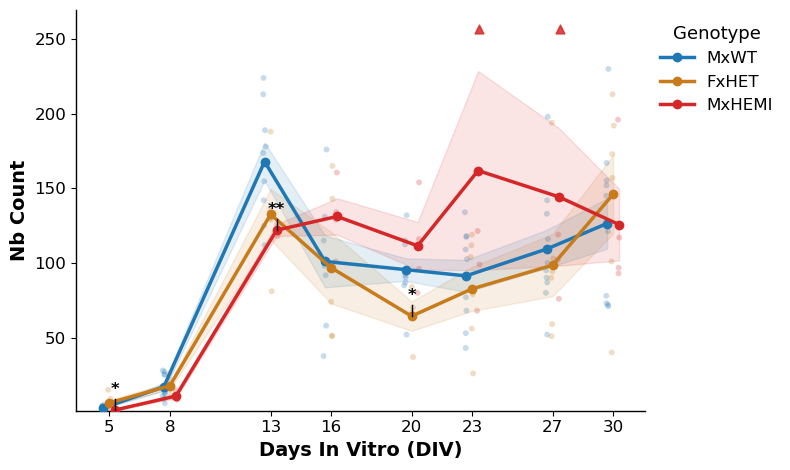

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

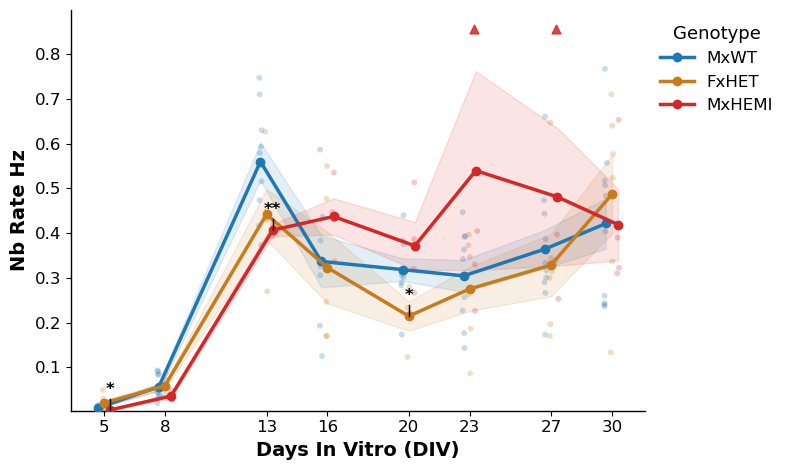

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

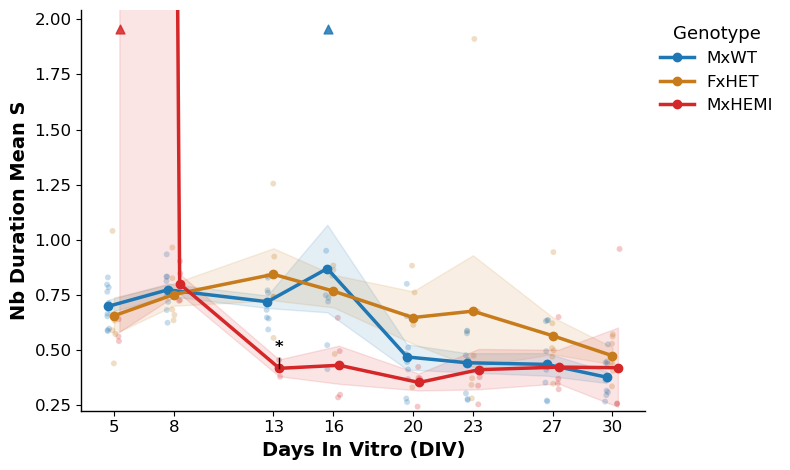

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

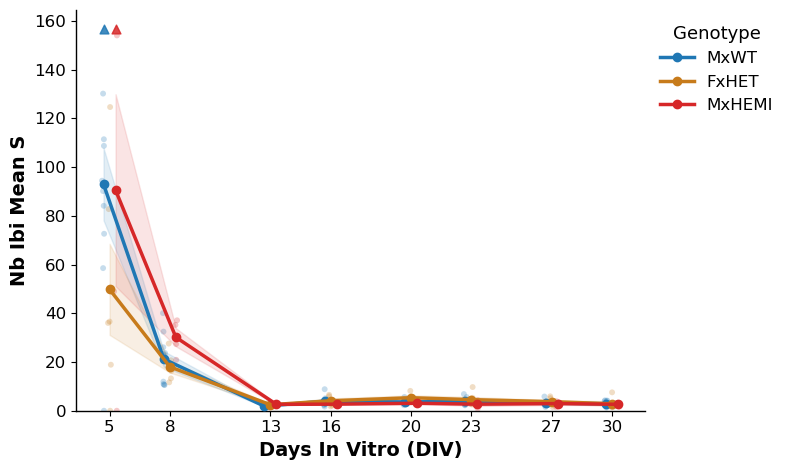

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

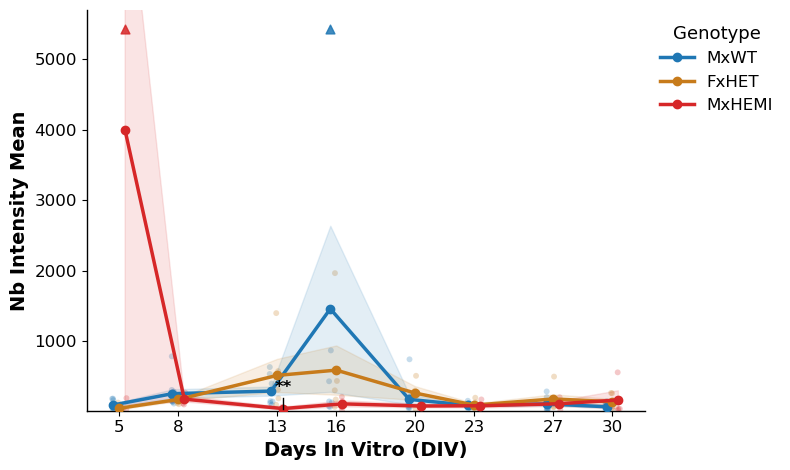

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

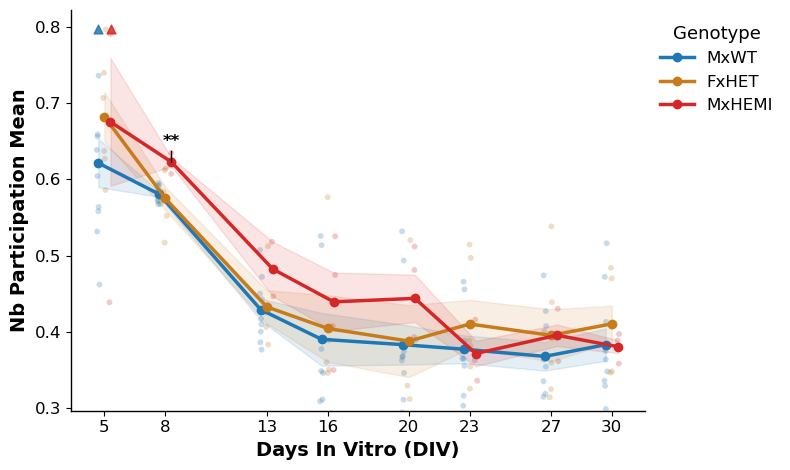

/global/homes/m/mpatil1/.conda/envs/spikeinterface/lib/python3.13/site-packages/pandas/core/groupby/generic.py:324: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f = lambda x: func(x, *args, **kwargs)
/global/homes/m/mpatil1/.conda/envs/spikeinterface/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.

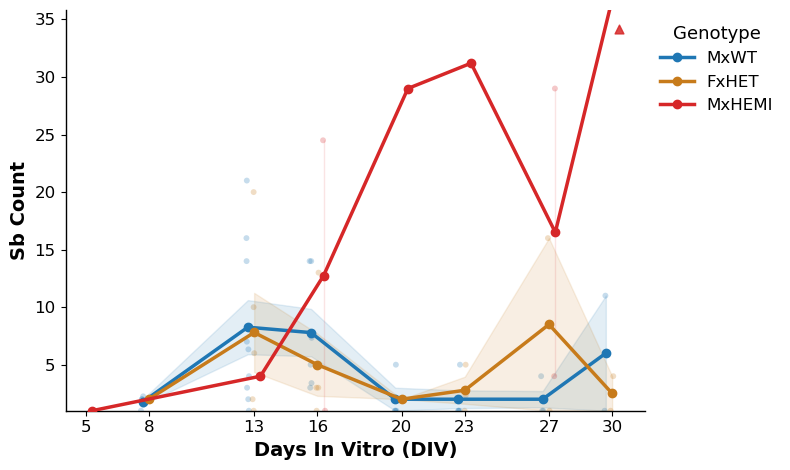

/global/homes/m/mpatil1/.conda/envs/spikeinterface/lib/python3.13/site-packages/pandas/core/groupby/generic.py:324: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f = lambda x: func(x, *args, **kwargs)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
fi

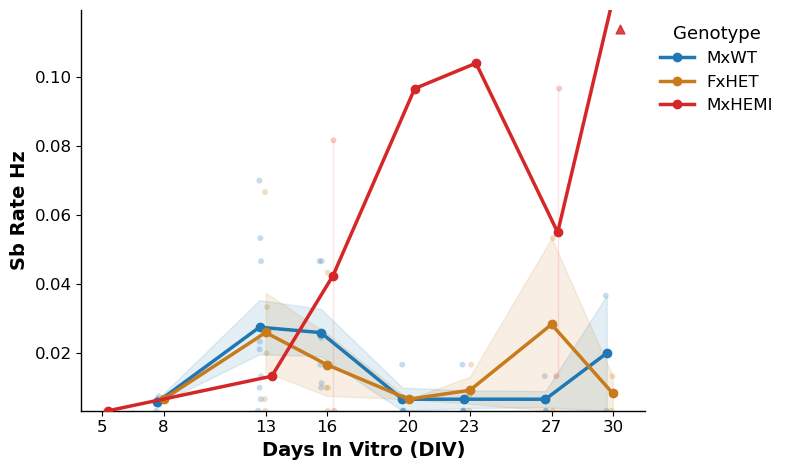

/global/homes/m/mpatil1/.conda/envs/spikeinterface/lib/python3.13/site-packages/pandas/core/groupby/generic.py:324: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f = lambda x: func(x, *args, **kwargs)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
fi

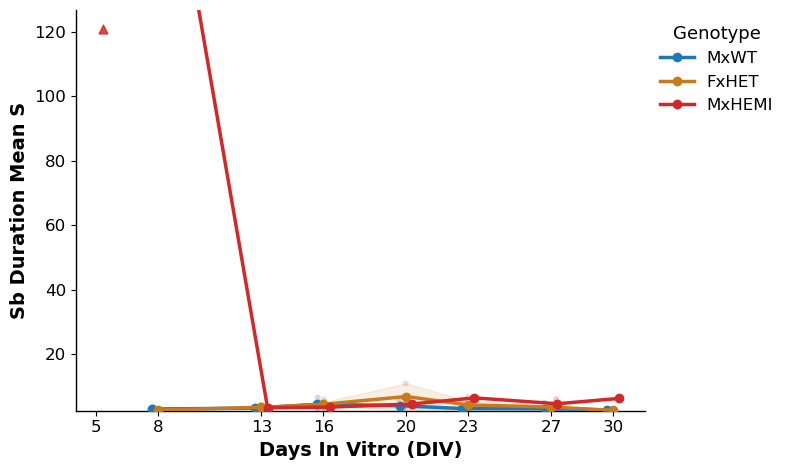

/global/homes/m/mpatil1/.conda/envs/spikeinterface/lib/python3.13/site-packages/pandas/core/groupby/generic.py:324: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f = lambda x: func(x, *args, **kwargs)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
fi

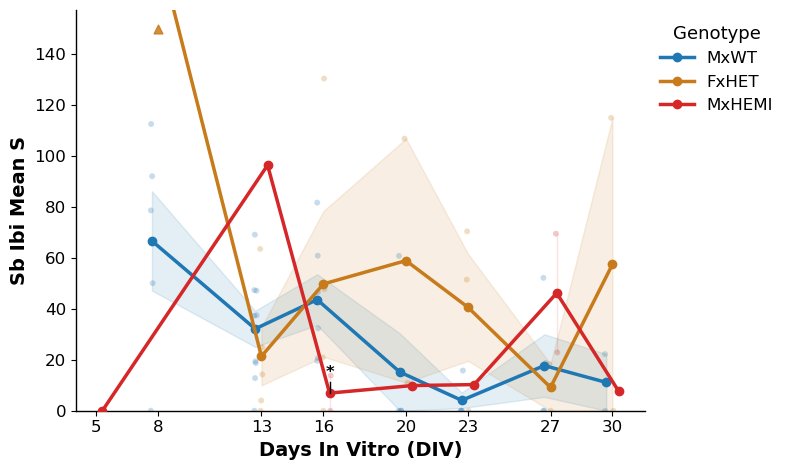

/global/homes/m/mpatil1/.conda/envs/spikeinterface/lib/python3.13/site-packages/pandas/core/groupby/generic.py:324: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f = lambda x: func(x, *args, **kwargs)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
fi

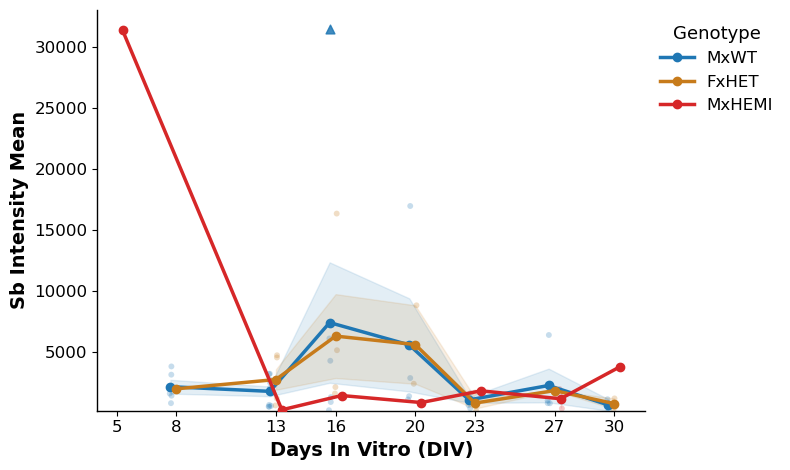

/global/homes/m/mpatil1/.conda/envs/spikeinterface/lib/python3.13/site-packages/pandas/core/groupby/generic.py:324: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f = lambda x: func(x, *args, **kwargs)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
fi

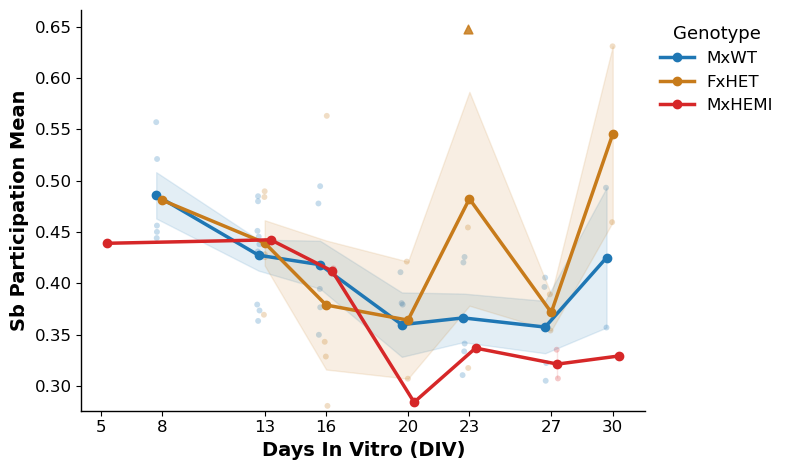

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

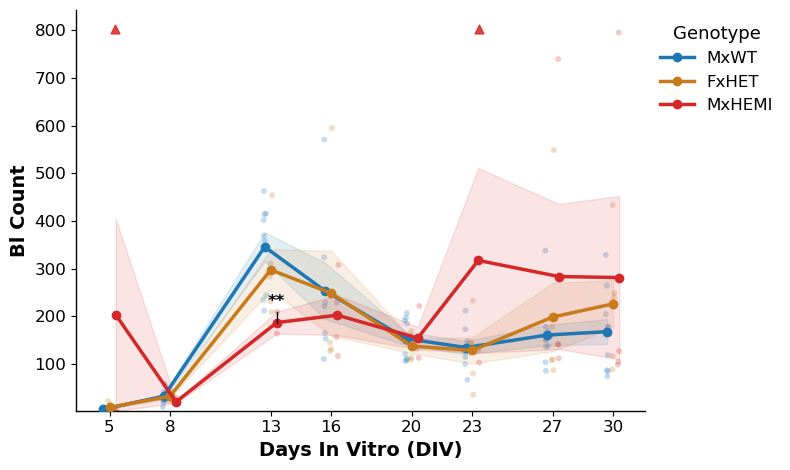

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

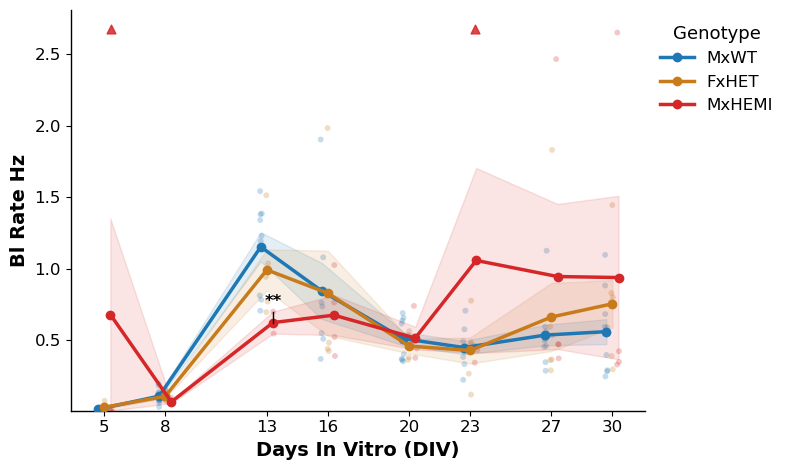

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

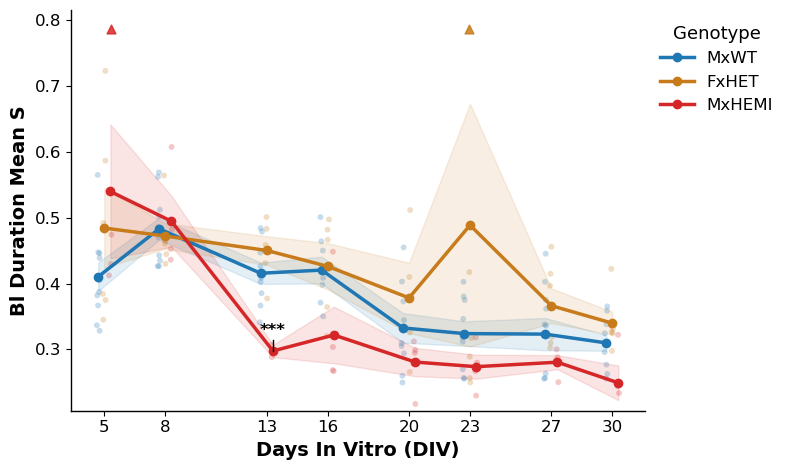

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

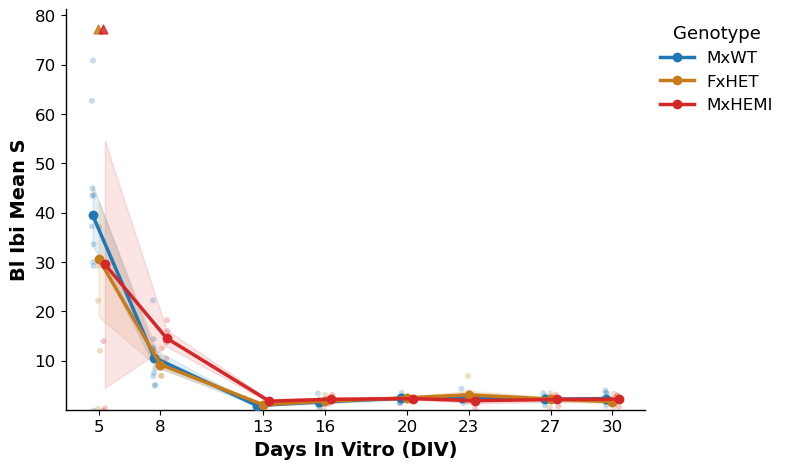

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

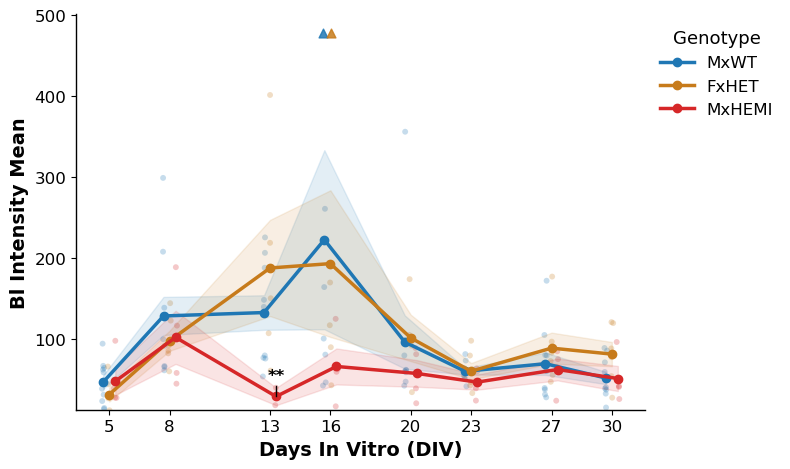

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

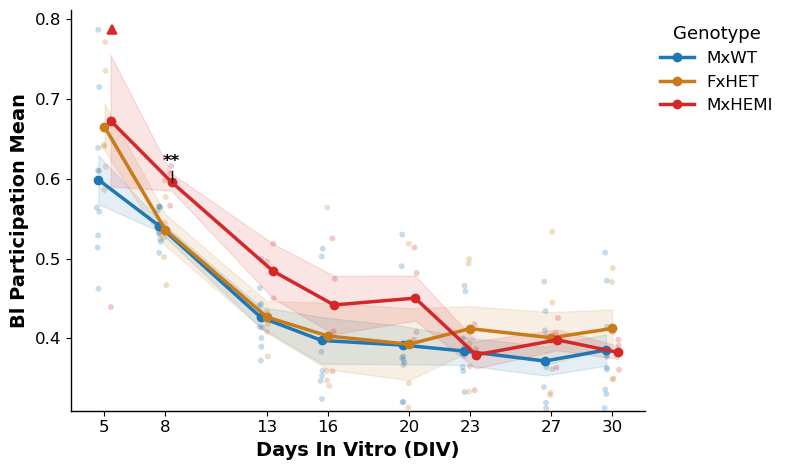

In [22]:
cols_to_plot = [ 'nb_count', 'nb_rate_hz', 'nb_duration_mean_s',
                'nb_ibi_mean_s', 'nb_intensity_mean', 'nb_participation_mean',
                'sb_count', 'sb_rate_hz', 'sb_duration_mean_s', 'sb_ibi_mean_s',
       'sb_intensity_mean', 'sb_participation_mean',
       'bl_count', 'bl_rate_hz', 'bl_duration_mean_s', 'bl_ibi_mean_s',
       'bl_intensity_mean', 'bl_participation_mean'
       ]
for col in cols_to_plot:
    plot_scalar_line_ttest_vs_control(
        merged_df,
        value_col=col,
        feature_label=col.replace('_', ' ').title(),
    )


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import sem
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

plt.rcParams.update({
    "font.family": "Arial",
    "axes.edgecolor": "black",
    "axes.linewidth": 1.0,
    "axes.labelsize": 14,
    "axes.labelweight": "bold",
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "legend.title_fontsize": 13,
    "xtick.direction": "out",
    "ytick.direction": "out"
})

def plot_feature_line_anova_tukey(
    df,
    list_col,
    feature_label=None,
    order=('MxWT','FxHET','MxHEMI'),
    palette={'MxWT':'#1f77b4','FxHET':'#c77b1b','MxHEMI':'#d62728'},
    save_path=None
):
    """Publication-quality lineplot of per-well mean metric across DIVs with ANOVA + Tukey"""

    # 1) Convert list column → numeric list
    num_col = f"{list_col}_Numeric"
    if num_col not in df.columns:
        df[num_col] = df[list_col].apply(
            lambda x: x if isinstance(x,list)
            else [float(i) for i in str(x).split(',')] if pd.notnull(x) else [])

    # 2) Build long form
    long_df = df[['DIV', 'Well', 'ID', 'NeuronType', num_col]].copy()
    long_df = long_df.rename(columns={num_col: 'Value_List'})
    long_df['ChipID_Well'] = long_df['ID'].astype(str) + '_W' + long_df['Well'].astype(str)
    long_df = long_df.explode('Value_List').reset_index(drop=True)
    long_df['Value'] = pd.to_numeric(long_df['Value_List'], errors='coerce')
    long_df.dropna(subset=['Value'], inplace=True)

    # 3) Aggregate mean per ChipID_Well × NeuronType × DIV
    agg_df = long_df.groupby(['DIV','ChipID_Well','NeuronType']).agg(mean_value=('Value','mean')).reset_index()

    # 4) Compute group summary (mean ± SEM)
    summary = (
        agg_df
        .groupby(['DIV','NeuronType'])
        .agg(mean_value=('mean_value','mean'), sem_value=('mean_value',sem))
        .reset_index()
    )

    divs = sorted(agg_df['DIV'].unique())
    group_offsets = {'MxWT': -0.5, 'FxHET': 0.0, 'MxHEMI': 0.5}

    # 5) Plot setup
    fig, ax = plt.subplots(figsize=(8, 4.8))

    # Scatter per well (background)
    for nt, color in palette.items():
        sub = agg_df[agg_df['NeuronType'] == nt]
        jitter = (np.random.rand(len(sub)) - 0.5) * 0.15
        ax.scatter(sub['DIV'] + jitter + group_offsets[nt],
                   sub['mean_value'], color=color, alpha=0.5, s=18, edgecolor='none')

    # Mean ± SEM lines (main layer)
    for nt, color in palette.items():
        sub = summary[summary['NeuronType'] == nt]
        offset = group_offsets[nt]
        ax.plot(sub['DIV'] + offset, sub['mean_value'], '-o',
                color=color, lw=3, zorder=3, label=nt)
        ax.fill_between(sub['DIV'] + offset,
                        sub['mean_value'] - sub['sem_value'],
                        sub['mean_value'] + sub['sem_value'],
                        color=color, alpha=0.25, zorder=2)

    # 6) ANOVA + Tukey tests per DIV
    tukey_sig = []
    for div in divs:
        sub = agg_df[agg_df['DIV'] == div]
        if sub['NeuronType'].nunique() < 2:
            continue
        model = ols('mean_value ~ C(NeuronType)', data=sub).fit()
        anova_results = anova_lm(model, typ=2)
        if 'C(NeuronType)' not in anova_results.index:
            continue
        p_anova = anova_results.loc['C(NeuronType)', 'PR(>F)']

        tuk = pairwise_tukeyhsd(sub['mean_value'], sub['NeuronType'], alpha=0.05)
        results_df = pd.DataFrame(tuk._results_table.data[1:], columns=tuk._results_table.data[0])

        for _, row in results_df.iterrows():
            if row['reject']:
                tukey_sig.append((div, row['group1'], row['group2'], float(row['p-adj'])))

    # --- IMPROVED SIGNIFICANCE ANNOTATIONS ---
    ymin, ymax = ax.get_ylim()
    yrange = ymax - ymin
    ax.set_ylim(ymin, ymax + yrange * 0.22)

    for div in divs:
        sig_pairs = [(d, s1, s2, p) for (d, s1, s2, p) in tukey_sig if d == div]
        if not sig_pairs:
            continue

        # Sort so that strongest (lowest p) is plotted on top
        sig_pairs.sort(key=lambda x: x[3])

        for k, (_, s1, s2, p_adj) in enumerate(sig_pairs):
            if p_adj < 0.001:
                sig = '***'
            elif p_adj < 0.01:
                sig = '**'
            elif p_adj < 0.05:
                sig = '*'
            else:
                continue

            # Horizontal alignment
            x1 = div + group_offsets[s1]
            x2 = div + group_offsets[s2]

            # Vertical positioning (scaled dynamically)
            base = ymax * 1.01 + (yrange * 0.05 * k)
            h = yrange * 0.015

            # Draw bracket + star
            ax.plot([x1, x1, x2, x2],
                    [base, base + h, base + h, base],
                    lw=0.9, c='k', clip_on=False)

            ax.text((x1 + x2) / 2, base + h * 1.25, sig,
                    ha='center', va='bottom',
                    fontsize=11, fontweight='bold',
                    color='k', clip_on=False)
    # 8) Final aesthetics
    ax.legend(title='Neuron Type', frameon=False, loc='upper left', bbox_to_anchor=(1.02, 1))
    ax.set_xlabel('Days In Vitro (DIV)', weight='bold')
    ax.set_ylabel(feature_label or list_col.replace('_', ' '), weight='bold')
    ax.tick_params(axis='both', labelsize=12, direction='out', length=4, width=1)
    ax.set_xticks(divs)
    ax.grid(alpha=0.2, linestyle='--', linewidth=0.5)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()

